## This is a quicklook notebook where I take the target pixel file Geert Barentsen gave me and turn it into a light curve, fit some transits and search for additional planets (spoiler: I didn't find any)

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits as pyfits
from astropy.stats.funcs import median_absolute_deviation as MAD
from scipy.ndimage import label

from fit_funcs import (bg_sub, get_label_im, get_lc, transit_fit,
                       get_qf, bin_data, model_ktransit, plot_model)
import untrendy

# i saved some dictionaries with planet parameters
from planet_params import *

# because I'm being sloppy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

In [2]:
f = pyfits.open('ktwo200164267-unofficial-tpf.fits')
data = f[1].data
print('{} cadences'.format(f[1].data['FLUX'].shape[0]))
print('pixel mask is {}'.format(f[1].data['FLUX'].shape[1:3]))

3599 cadences
pixel mask is (11, 11)


lets take a look at what the star looks like

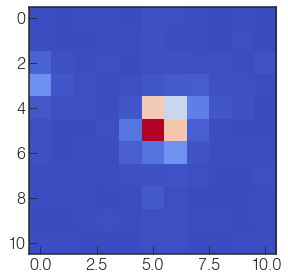

In [3]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal')
plt.tight_layout()

These are some constants that I fiddled around with a found seemed to work best

In [4]:
bg_cut = 1.8
n_chunks = 7.
flatlc_window = 1.5
smooth_window = 0.6

I'm going to extract flux from the flagged pixels

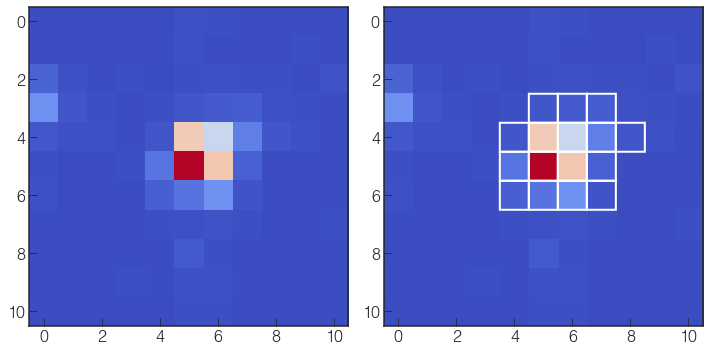

In [5]:
lab_im = get_label_im(np.copy(f[1].data['FLUX']), bg_cut)

fig, [ax1,ax] = plt.subplots(1, 2, figsize=[10,5])
ax.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal')
ax1.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal')
for i in range(11):
    for j in range(11):
        if lab_im[j,i] == 1:
            ax.add_patch(mpl.patches.Rectangle((i-.5, j-.5), 1, 1, hatch='', fill=False, snap=False, color='w', 
                                               lw=2))

plt.tight_layout()

I'm going to remove some cadences where we fire a thruster and remove energy from the reaction wheels, called a resat. Also, something weird happens with the pointing at the end of the campaign

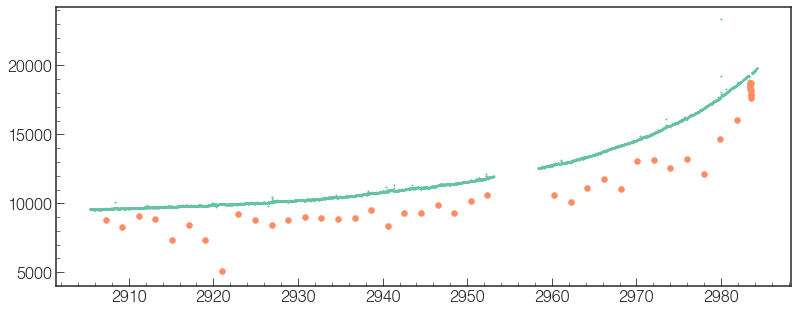

In [6]:
q1 = np.array([])
for i in np.arange(f[1].data['TIME'].shape[0]):
    q1 = np.r_[q1,np.sum(f[1].data['FLUX'][i][lab_im > 0.0])]

plt.figure(figsize=[12,5])
plt.scatter(f[1].data['TIME'],q1, s=2)

q = untrendy.median(f[1].data['TIME'],q1,dt=2)

plt.scatter(f[1].data['TIME'][(q1-q)<-500],q1[(q1-q)<-500])

badbadbad = (q1-q)<-500

plt.minorticks_on()

ok now let's make a light curve, this uses a methods that's almost exactly like Andrew Vanderburg's

In [7]:
quality = np.zeros_like(np.copy(f[1].data['TIME']))
quality[badbadbad] = 100.
time, lc, xbar, ybar, t1, corflux, cfflux = get_lc(
    np.copy(f[1].data['TIME']), np.copy(f[1].data['FLUX']), 
    quality, n_chunks, bg_cut, flatlc_window, smooth_window)

lets make some plots
* undetrended light curve
* undetrended and the detrending model of the spots [it's a silly median filter]
* final product

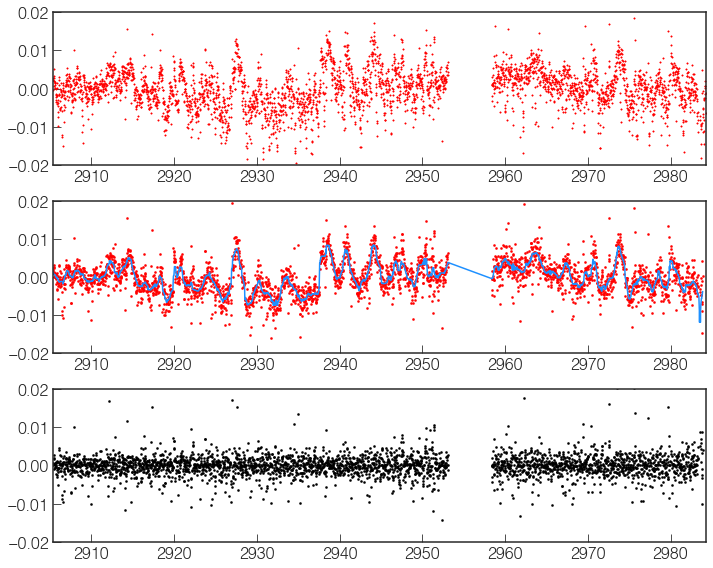

In [8]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=[10,8])
ax1.scatter(time,lc/np.median(lc)-1.0, color='r', s=2)
ax1.set_ylim([-0.02,0.02])
ax1.set_xlim(np.min(time), np.max(time))

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,corflux-1.0, color='r',s=4)
ax2.plot(t1, q-1.0, color='dodgerblue')
ax2.set_ylim([-0.02,0.02])
ax2.set_xlim(np.min(time), np.max(time))

ax3.set_ylim([-0.02,0.02])
ax3.set_xlim(np.min(time), np.max(time))
ax3.scatter(t1,cfflux, color='k',s=4)


fig.tight_layout()


## hurray! let's save this data

In [9]:
outdata = np.array([t1,cfflux]).T
np.savetxt('trappist1-barclay.csv', outdata, delimiter=',',)

ok, now let's try to model the planets

In [10]:
time, flux, fitT = transit_fit(t1, cfflux)

fitT.print_results() 

Best-fitting stellar parameters
zpt: 0.000130841029516
rho: 44.1328598083

Best-fitting planet parameters for planet 0
impact: 0.677157639928
period: 1.51097895099
T0: 7322.4842649
rprs: 0.0936688857411

Best-fitting planet parameters for planet 1
impact: 0.663685917696
period: 2.42192670638
T0: 7282.78349602
rprs: 0.0981659548192

Best-fitting planet parameters for planet 2
impact: 0.521403805005
period: 4.05050843177
T0: 7670.12765371
rprs: 0.0668164123259

Best-fitting planet parameters for planet 3
impact: 0.612581778764
period: 6.09949059695
T0: 7660.37143114
rprs: 0.0760127675828

Best-fitting planet parameters for planet 4
impact: 0.489551123917
period: 9.20797102269
T0: 7671.36027592
rprs: 0.0742213220711

Best-fitting planet parameters for planet 5
impact: 0.806908177806
period: 12.3544647906
T0: 7665.35535374
rprs: 0.098777010225

Best-fitting planet parameters for planet 6
impact: 0.48929675276
period: 24.4740823147
T0: 7759.87204563
rprs: 0.0735766866535



(-0.015, 0.005)

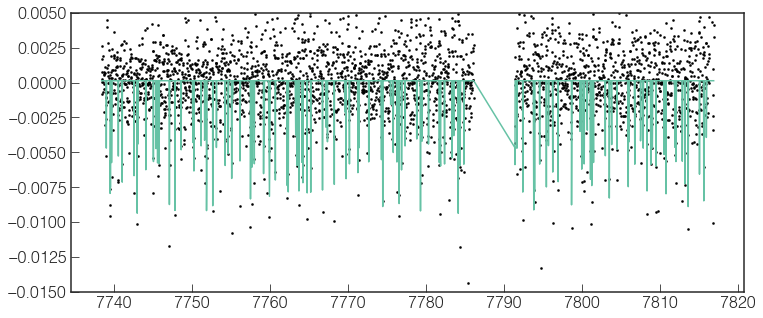

In [11]:
# here are all the transits!!
fig, ax = plt.subplots(1, 1, figsize=[11,5])
ax.scatter(time,flux, color='k',s=4)
ax.plot(time,fitT.transitmodel)
ax.set_ylim(-0.015,0.005)

In [ ]:
# some fixe
ld1 = 0.43
ld2 = 0.14
zpt = fitT.fitresultstellar['zpt']
rho = 50.0